In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import scipy.io as sio
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torchvision.utils import make_grid
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
torch.cuda.is_available()
torch.cuda.get_device_name(0)

'GeForce GTX 1060 6GB'

In [ ]:
# for colab
# scipy_sio = sio.loadmat('/content/drive/My Drive/Colab Notebooks/cars_annos.mat', squeeze_me = True)   
# scipy_sio

In [4]:
scipy_sio = sio.loadmat('cars_annos.mat', squeeze_me = True)   
scipy_sio

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sat Feb 28 19:34:55 2015',
 '__version__': '1.0',
 '__globals__': [],
 'annotations': array([('car_ims/000001.jpg', 112, 7, 853, 717, 1, 0),
        ('car_ims/000002.jpg', 48, 24, 441, 202, 1, 0),
        ('car_ims/000003.jpg', 7, 4, 277, 180, 1, 0), ...,
        ('car_ims/016183.jpg', 25, 32, 587, 359, 196, 1),
        ('car_ims/016184.jpg', 56, 60, 208, 186, 196, 1),
        ('car_ims/016185.jpg', 1, 1, 200, 131, 196, 1)],
       dtype=[('relative_im_path', 'O'), ('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('test', 'O')]),
 'class_names': array(['AM General Hummer SUV 2000', 'Acura RL Sedan 2012',
        'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
        'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
        'Acura ZDX Hatchback 2012',
        'Aston Martin V8 Vantage Convertible 2012',
        'Aston Martin V8 Vantage Coupe 2012',
        'Aston Martin Virage C

In [5]:
#extract class_names
class_name = scipy_sio['class_names']
class_name[0:10]
# has linkage to annotation['class']

array(['AM General Hummer SUV 2000', 'Acura RL Sedan 2012',
       'Acura TL Sedan 2012', 'Acura TL Type-S 2008',
       'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
       'Acura ZDX Hatchback 2012',
       'Aston Martin V8 Vantage Convertible 2012',
       'Aston Martin V8 Vantage Coupe 2012',
       'Aston Martin Virage Convertible 2012'], dtype=object)

In [6]:
#extract annotations, contains 7 variables
annotation = scipy_sio['annotations']
annotation[0:5]
# 7 values:
# 0: relative_im_path:  image location & name
# 1: bbox_x1:           Min x-value of the bounding box, in pixels
# 2: bbox_y1:           Min y-value of the bounding box, in pixels
# 3: bbox_x2:           Max x-value of the bounding box, in pixels
# 4: bbox_y2:           Max y-value of the bounding box, in pixels
# 5: class:             Target model, ex: img 000001-000003 have class = 1, so it is 'AM General Hummer SUV 2000'
# 6: test:              test = 1, train = 0


array([('car_ims/000001.jpg', 112, 7, 853, 717, 1, 0),
       ('car_ims/000002.jpg', 48, 24, 441, 202, 1, 0),
       ('car_ims/000003.jpg', 7, 4, 277, 180, 1, 0),
       ('car_ims/000004.jpg', 33, 50, 197, 150, 1, 0),
       ('car_ims/000005.jpg', 5, 8, 83, 58, 1, 0)],
      dtype=[('relative_im_path', 'O'), ('bbox_x1', 'O'), ('bbox_y1', 'O'), ('bbox_x2', 'O'), ('bbox_y2', 'O'), ('class', 'O'), ('test', 'O')])

In [7]:
#convert annotation [array of tuples] to 1D array
annotation_array = [a for b in annotation for a in b]
annotation_array[0:14]

['car_ims/000001.jpg',
 112,
 7,
 853,
 717,
 1,
 0,
 'car_ims/000002.jpg',
 48,
 24,
 441,
 202,
 1,
 0]

In [8]:
#convert 1D array into 7d array/matrix
annotation_matrix = np.reshape(annotation_array, (-1,7))
#annotation_matrix = annotation_matrix.tolist()    #remove dtype
annotation_matrix[0:5]

array([['car_ims/000001.jpg', '112', '7', '853', '717', '1', '0'],
       ['car_ims/000002.jpg', '48', '24', '441', '202', '1', '0'],
       ['car_ims/000003.jpg', '7', '4', '277', '180', '1', '0'],
       ['car_ims/000004.jpg', '33', '50', '197', '150', '1', '0'],
       ['car_ims/000005.jpg', '5', '8', '83', '58', '1', '0']],
      dtype='<U18')

In [109]:
# ex: extract class variable
tgt_class = annotation_matrix[:,5]
tgt_class = tgt_class.tolist()
len(tgt_class)

16185

In [10]:
len(np.unique(tgt_class))
#there are 196 unique classes in annotation matrix

196

In [11]:
len(np.unique(class_name))
#there are 196 different classes in array class_name

196

In [51]:
# frequency function
import collections 
def CountFrequency(arr): 
    return collections.Counter(arr)  




overall target class frequency, 196 unique classes across 16185 imgs


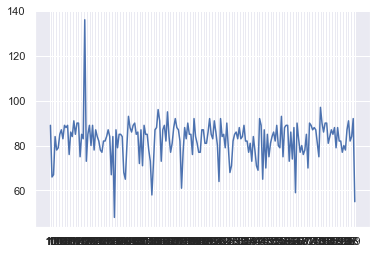

In [52]:
import matplotlib.pylab as plt
#overall target class frequency, 196 unique classes across 16185 imgs

freq = CountFrequency(tgt_class) 
lists = sorted(freq.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
print('overall target class frequency, 196 unique classes across 16185 imgs')
plt.plot(x, y)
plt.show()

In [106]:
import statistics

std  = statistics.stdev(y)
mean = statistics.mean(y)

gt_2stdv=[]
ind_count=[]
classID_name=[]
for classID, count in freq.items():    
    if count > (mean+std*2) or count < (mean-std*2):
        gt_2stdv.append(classID)  
        ind_count.append(count)
        classID_name.append(class_name[int(classID)])
print("Target ClassIDs that have records count out side 2stdv:\n ID: {}".format(gt_2stdv))
print("Count: {}".format(ind_count))
print("name: {}".format(classID_name))
print("std = {}".format(std))
print("mean = {}".format(mean))


Target ClassIDs that have records count out side 2stdv:
 ID: ['2', '45', '64', '99', '119', '136', '142', '158', '175']
Count: [64, 65, 59, 55, 136, 48, 65, 58, 61]
name: ['Acura TL Sedan 2012', 'Bugatti Veyron 16.4 Coupe 2009', 'Chevrolet Avalanche Crew Cab 2012', 'FIAT 500 Convertible 2012', 'GMC Yukon Hybrid SUV 2012', 'Hyundai Genesis Sedan 2012', 'Isuzu Ascender SUV 2008', 'Mazda Tribute SUV 2011', 'Rolls-Royce Ghost Sedan 2012']
std = 8.69006271282919
mean = 82.5765306122449


In [184]:
#check if there is any unbalance in train/test dataset
train_test = annotation_matrix[:,5:]
train = train_test[train_test[:,1]=='0',0].tolist()
test = train_test[train_test[:,1]=='1',0].tolist()
#train_test = train_test.tolist()
print("# of Training Imgs: {}".format(len(train)))
print("# of Test Imgs: {}".format(len(test)))

# of Training Imgs: 8144
# of Test Imgs: 8041


print the distribution for train


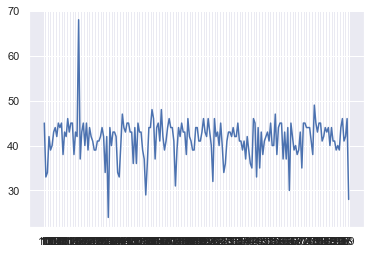

In [186]:
# print the distribution for train
freq_train = CountFrequency(train) 
lists = sorted(freq_train.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
print('distribution for training dataset')
plt.plot(x, y)
plt.show()

print the distribution for test


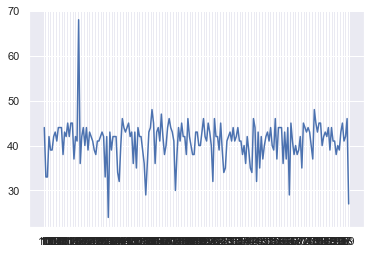

In [187]:
# print the distribution for train
freq_test = CountFrequency(test) 
lists = sorted(freq_test.items()) # sorted by key, return a list of tuples
x, y = zip(*lists)
print('distribution for test dataset')
plt.plot(x, y)
plt.show()

In [232]:
freq_train_val = list(freq_train.values())
freq_test_val = list(freq_test.values())
classID = list(freq_train.keys())
off_by_array = []
for i in range(len(freq_train)):
    off_by = abs(freq_train_val[i]-freq_test_val[i])
    off_by_array.append(off_by)
    classID_name = class_name[i]
    
    print("target class: {}-{} || train vs test vol off by: {}".format(i,classID_name,off_by))
print("the average difference between\n training & testing is off by {} ".format(np.average(off_by_array)))    

target class: 0-AM General Hummer SUV 2000 || train vs test vol off by: 1
target class: 1-Acura RL Sedan 2012 || train vs test vol off by: 0
target class: 2-Acura TL Sedan 2012 || train vs test vol off by: 0
target class: 3-Acura TL Type-S 2008 || train vs test vol off by: 0
target class: 4-Acura TSX Sedan 2012 || train vs test vol off by: 1
target class: 5-Acura Integra Type R 2001 || train vs test vol off by: 1
target class: 6-Acura ZDX Hatchback 2012 || train vs test vol off by: 0
target class: 7-Aston Martin V8 Vantage Convertible 2012 || train vs test vol off by: 0
target class: 8-Aston Martin V8 Vantage Coupe 2012 || train vs test vol off by: 0
target class: 9-Aston Martin Virage Convertible 2012 || train vs test vol off by: 0
target class: 10-Aston Martin Virage Coupe 2012 || train vs test vol off by: 0
target class: 11-Audi RS 4 Convertible 2008 || train vs test vol off by: 1
target class: 12-Audi A5 Coupe 2012 || train vs test vol off by: 0
target class: 13-Audi TTS Coupe 2012

target class: 107-Ford Freestar Minivan 2007 || train vs test vol off by: 0
target class: 108-Ford Expedition EL SUV 2009 || train vs test vol off by: 1
target class: 109-Ford Edge SUV 2012 || train vs test vol off by: 0
target class: 110-Ford Ranger SuperCab 2011 || train vs test vol off by: 0
target class: 111-Ford GT Coupe 2006 || train vs test vol off by: 1
target class: 112-Ford F-150 Regular Cab 2012 || train vs test vol off by: 1
target class: 113-Ford F-150 Regular Cab 2007 || train vs test vol off by: 0
target class: 114-Ford Focus Sedan 2007 || train vs test vol off by: 0
target class: 115-Ford E-Series Wagon Van 2012 || train vs test vol off by: 1
target class: 116-Ford Fiesta Sedan 2012 || train vs test vol off by: 1
target class: 117-GMC Terrain SUV 2012 || train vs test vol off by: 1
target class: 118-GMC Savana Van 2012 || train vs test vol off by: 0
target class: 119-GMC Yukon Hybrid SUV 2012 || train vs test vol off by: 1
target class: 120-GMC Acadia SUV 2012 || train 

In [218]:
classID = list(freq_train.keys())
classID[3]

'4'

In [219]:
classID

['1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '80',
 '81',
 '82',
 '83',
 '84',
 '85',
 '86',
 '87',
 '88',
 '89',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '97',
 '98',
 '99',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '13